## Training a sentiment analysis classifier based on supervised machine learning algorithms

In [1]:
import string

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
stop_words = set(stopwords.words('spanish'))

In [4]:
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

### Loading labeled tweets

In [5]:
# Dataset loaded from: https://docs.google.com/spreadsheets/d/11_E2ngsEOyTQwbwVVRHY5urzFF95BQCV/edit#gid=1788161364
tweets_df = pd.read_csv('./data/tweets_labeled.csv', sep = ',')

In [6]:
tweets_df.shape

(296, 2)

In [7]:
tweets_df.head()

,full_text,sentiment
0,@Nata_Salud @Sandrag69 @AndresMejiaV ¡Hola Natalia! Te invitamos a descubrir tu #MatchPresidencial aquí: https://t.co/0E1tZKypTK,neutral
1,@supershadai @Registraduria Quien o que institución en Colombia atiende los reclamos al fraude electoral?\nPorque no suspender a al registrador que ya la defeco en las elecciones de senado y camara.\nHay una desconfianza general en cuanto a las presidenciales.\nEstán provocando una respuesta violenta.,negative
2,@BOLIBAR2 @AndresPastrana_ @santiagoangelp Un poco tarde con las elecciones encima… mal para Colombia,negative
3,"No encontraron otra alternativa que llenar de miedo a Colombia, utilizan sus paramilitares para ganar elecciones. Es ahora o nunca @petrogustavo",positive
4,"@BOLIBAR2 @CNE_COLOMBIA @AndresPastrana_ Aquí no va a pasar nada, y petro de va a robar las elecciones presidenciales y el país",negative


In [8]:
tweets_df['sentiment'].value_counts(dropna = False, normalize = True)

negative    0.668919
neutral     0.270270
positive    0.060811
Name: sentiment, dtype: float64

### Leaving out unlabeled texts, this data is not useful for training or validating a supervised model

In [9]:
# Removing  unlabeled tweets
tweets_labeled_df = tweets_df.loc[tweets_df['sentiment'].notnull()]

In [10]:
tweets_labeled_df.shape

(296, 2)

In [11]:
tweets_unlabeled_df = tweets_df.loc[tweets_df['sentiment'].isnull()]

In [12]:
tweets_unlabeled_df.shape

(0, 2)

In [13]:
# Scenario 2: Working only with positive and negative classes
# Removing neutral class
tweets_labeled_df = tweets_labeled_df.loc[tweets_labeled_df['sentiment'].isin(['positive', 'negative'])]

### Splitting train and test datasets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(tweets_labeled_df['full_text'], tweets_labeled_df['sentiment'], test_size = 0.2, stratify = tweets_labeled_df['sentiment'], random_state = 1)


In [15]:
X_train.shape

(172,)

In [16]:
pd.Series(y_train).value_counts(normalize = True)

negative    0.918605
positive    0.081395
Name: sentiment, dtype: float64

In [17]:
X_test.shape

(44,)

In [18]:
pd.Series(y_test).value_counts(normalize = True)

negative    0.909091
positive    0.090909
Name: sentiment, dtype: float64

### Vectorizing texts

<table>
    <tbody>
        <tr>
            <td>
                <h4>Bag of Words</h4>
                <img src="imgs/bow.png" style="width: 500px;">
            </td>
            <td>
                <h4>TF-IDF</h4>
                <img src="imgs/tf-idf.png" style="width: 500px;">
            </td>
        </tr>
    </tbody>
</table>

In [19]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [20]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [21]:
X_bow = bow.fit_transform(X_train)

In [22]:
X_tfidf = tfidf.fit_transform(X_train)

### Training and evaluating a model using BOW

In [23]:
model = DecisionTreeClassifier(max_depth=6)

In [24]:
model.fit(X_bow, y_train)

DecisionTreeClassifier(max_depth=6)

In [25]:
y_train_bow_predict = model.predict(X_bow)
y_test_bow_predict = model.predict(bow.transform(X_test))

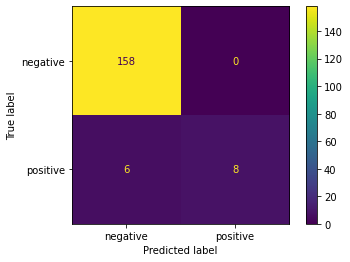

In [26]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

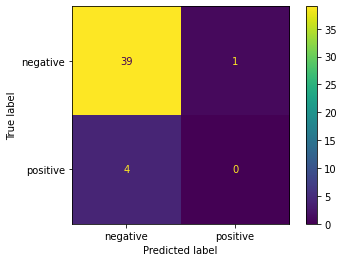

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [28]:
# Metrics calculation for more than two classes
print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: [0.90697674 0.        ]
Recall: [0.975 0.   ]
F1: [0.93975904 0.        ]


### Training and evaluating a model using TF-IDF

In [29]:
model = DecisionTreeClassifier(max_depth=6)

In [30]:
model.fit(X_tfidf, y_train)

DecisionTreeClassifier(max_depth=6)

In [31]:
y_train_tfidf_predict = model.predict(X_tfidf)
y_test_tfidf_predict = model.predict(bow.transform(X_test))

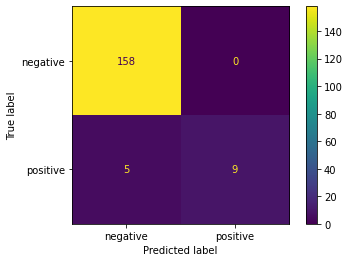

In [32]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

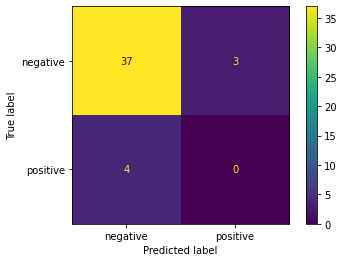

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [34]:
# Metrics calculation for more than two classes
print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: [0.90243902 0.        ]
Recall: [0.925 0.   ]
F1: [0.91358025 0.        ]


### How interpret the results?

### Analyzing errors Bag of Words

In [35]:
error_df1 = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_bow_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df1.drop('index', inplace = True, axis = 1)

In [36]:
error_df1.shape

(44, 3)

In [37]:
error_df1.loc[error_df1['actual'] != error_df1['predicted']].head(20)

,full_text,actual,predicted
0,"Viví de cerca el CAMBIO de Venezuela.\n\nFue el pais más rico de América Latina, hoy su economía está destruida.\n\nA punta de decretos acaban connlas empresas y la que sobrevive la expropian.\n\nColombia es anticomunista y lo demostraremos en las próximas elecciones.",negative,positive
3,Eso sabe ;)\nAdelante #PetroPresidente2022 \nhttps://t.co/xscQ26b62m https://t.co/NIJNT0Sms7,positive,negative
8,@CARLOSFMEJIA @infopresidencia @PGN_COL @FiscaliaCol @CNE_COLOMBIA Así es.\nEs lo correcto.\nHacer bien las elecciones.\nEsa es democracia.,positive,negative
19,"@RenataSokolov A ustedes, la derecha, buscando alterar el orden público para suspender elecciones y perpetuar el régimen de terror que pretende amedrentarnos...pero Colombia dijo no más y con Petro ganaremos en primera vuelta.",positive,negative
35,"El candidato presidencial del Pacto Histórico retomó su actividad en tarimas, a pesar de las amenazas que denunció esta semana. Cúcuta y Valledupar son las ciudades en las que reanudó su agenda.\nhttps://t.co/kDmmaQuF1v",positive,negative


### Analyzing errors TF-IDF

In [38]:
error_df2 = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_tfidf_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df2.drop('index', inplace = True, axis = 1)

In [39]:
error_df2.shape

(44, 3)

In [40]:
error_df2.loc[error_df2['actual'] != error_df2['predicted']].head(20)

,full_text,actual,predicted
0,"Viví de cerca el CAMBIO de Venezuela.\n\nFue el pais más rico de América Latina, hoy su economía está destruida.\n\nA punta de decretos acaban connlas empresas y la que sobrevive la expropian.\n\nColombia es anticomunista y lo demostraremos en las próximas elecciones.",negative,positive
3,Eso sabe ;)\nAdelante #PetroPresidente2022 \nhttps://t.co/xscQ26b62m https://t.co/NIJNT0Sms7,positive,negative
8,@CARLOSFMEJIA @infopresidencia @PGN_COL @FiscaliaCol @CNE_COLOMBIA Así es.\nEs lo correcto.\nHacer bien las elecciones.\nEsa es democracia.,positive,negative
10,gobernante mas nefasto en la historia de colombia! 90% desaprobación \n@IvanDuque te recordaremos el dia de las elecciones no permitir otro URIBISTA mas en el poder @FicoGutierrez con el historial mas oscuro y aliado de los que tiene el pais en paro! Su comandate @AlvaroUribeVel https://t.co/SeJtRYJOV6,negative,positive
14,"@PGN_COL @RedMasNoticias @NoticiasCaracol @NoticiasRCN @elespectador @ElNuevoSiglo @AtlanticoEmi @larepublica_co @elheraldoco @RevistaSemana @BluRadioCo Las elecciones en Colombia fueron un fraude debe anularlas y las de presidencia deben aplazarlas no hay GARANTÍAS, hubo un PACTO DE ROBO Y ATRACÓ AL PAIS",negative,positive
19,"@RenataSokolov A ustedes, la derecha, buscando alterar el orden público para suspender elecciones y perpetuar el régimen de terror que pretende amedrentarnos...pero Colombia dijo no más y con Petro ganaremos en primera vuelta.",positive,negative
35,"El candidato presidencial del Pacto Histórico retomó su actividad en tarimas, a pesar de las amenazas que denunció esta semana. Cúcuta y Valledupar son las ciudades en las que reanudó su agenda.\nhttps://t.co/kDmmaQuF1v",positive,negative
